In [1]:
import pandas as pd
import torch

from PIL import Image
import glob
import os
import matplotlib.pyplot as plt
import datetime

import torch.nn.functional as F
import torch.optim as optim
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
#from torchsummary import summary

from tqdm.notebook import tqdm

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

print(torch.__version__)

headder = "/home/kashihara/workspace/2022MAiZM/2022MAiZM_data"

cuda:0
1.10.1+cu111


In [21]:
class my_dataset(Dataset):
    def __init__(self, img_path,transform=None):
        
        image_paths = glob.glob(img_path + '/*.jpg')
        labels = os.path.basename(img_path)

        self.image_paths = image_paths
        self.labels = 0 
        self.transform = transform

    def __getitem__(self, index):
        path = self.image_paths[index] 
        #画像読み込み。
        img = Image.open(path)
        #transform事前処理実施
        if self.transform is not None:
            img = self.transform(img)

        label=self.labels
        image_path=self.image_paths[index]
        return img,label

    def __len__(self):
        return len(self.image_paths)

if __name__ == '__main__':
    transform_train = transforms.Compose([transforms.CenterCrop(1080),
                                          transforms.RandomAffine(degrees=[-10, 10], translate=(0.05,0.05)),
                                          transforms.RandomVerticalFlip(p=0.8),
                                          transforms.CenterCrop(840),
                                          transforms.Resize((256,256)), 
                                          transforms.ToTensor()])
    
    transform_test = transforms.Compose([transforms.CenterCrop(1080),
                                         transforms.CenterCrop(840),
                                         transforms.Resize((256,256)),
                                         transforms.ToTensor()])
    #データセット作成
    dataset = my_dataset("{}/data/train".format(headder),transform)
    #dataloader化
    dataloader = DataLoader(dataset, batch_size=32)

    test_dataset = my_dataset("{}/data/test".format(headder),transform)
    #dataloader化
    test_dataloader = DataLoader(test_dataset, batch_size=8)
    


In [22]:
!ls

AE_train_iwamoto.ipynb	  VAE_color_pred_96.ipynb
VAE.ipynb		  VAE_color_train_128.ipynb
VAE_color_pred_128.ipynb  VAE_color_train_256.ipynb
VAE_color_pred_256.ipynb  VAE_color_train_256_2.ipynb


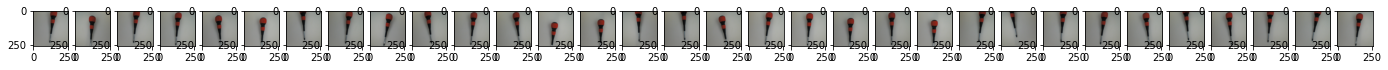

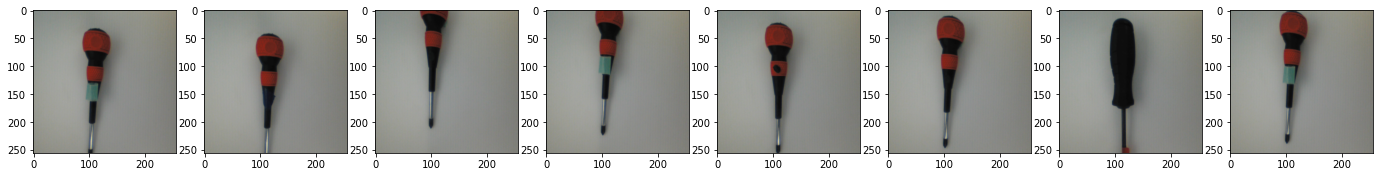

In [23]:
fig=plt.figure(figsize=(24, 12))

for a in dataloader:
    for num,img in enumerate(a[0]):
        fig.add_subplot(1,len(a[0]), num+1)
        plt.imshow(img.cpu().numpy().swapaxes(0,2))
    break

fig=plt.figure(figsize=(24, 12))

for b in test_dataloader:
    for num,img in enumerate(b[0]):
        fig.add_subplot(1,len(b[0]), num+1)
        plt.imshow(img.cpu().numpy().swapaxes(0,2))
    break

In [ ]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, 5, stride=2, padding=2)
        self.conv2 = nn.Conv2d(32, 16, 5, stride=2, padding=2)
        self.conv3 = nn.Conv2d(16,  8, 5, stride=2, padding=2)

        self.max_pool = nn.MaxPool2d(kernel_size = 2, stride = 2)

        self.fc1_mu = nn.Linear(8 * 16 * 16 , 100)
        self.fc1_sig = nn.Linear(8 * 16 * 16 , 100)
        self.fc2 = nn.Linear(100, 8 * 16 * 16 )

        self.up_sample = nn.UpsamplingNearest2d(scale_factor=2)

        self.conv4 = nn.ConvTranspose2d(8, 32, 6, stride=2, padding=2)
        self.conv5 = nn.ConvTranspose2d(32, 16, 6, stride=2, padding=2)
        self.conv6 = nn.ConvTranspose2d(16, 3, 6, stride=2, padding=2)


    def encode(self,x):
        #print(x.shape)
        a1 = F.relu(self.conv1(x))
        #print(a1.shape)
        a2 = F.relu(self.conv2(a1))
        #print(a2.shape)
        a3 = F.relu(self.conv3(a2))
        #print(a3.shape)
        mx_poold = self.max_pool(a3)
        #print(mx_poold.shape)
        a_reshaped = mx_poold.reshape(-1, 8 * 16 * 16 )
        #print(a_reshaped.shape)

        a_mu = self.fc1_mu(a_reshaped)
        #print(a_mu.shape)
        a_logvar = self.fc1_sig(a_reshaped)
        
        return a_mu, a_logvar

    def decode(self,z):
        a3 = F.relu(self.fc2(z))
        #print(a3.shape)
        a3 = a3.reshape(-1, 8, 16, 16)
        #print(a3.shape)
        a3_upsample = self.up_sample(a3)
        #print(a3_upsample.shape)
        a4 = F.relu(self.conv4(a3_upsample))
        #print(a4.shape)
        a5 = F.relu(self.conv5(a4))
        #print(a5.shape)
        a6 = torch.sigmoid(self.conv6(a5))
        #print(a6.shape)
        return a6

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def forward(self,x):
        #print(x.shape)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [ ]:

model = Net()  
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [ ]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())#pow=2乗 exp()=自然対数の底

    return BCE + KLD

In [ ]:
num_epochs = 10000 #学習回数
print_per = 100
model.train()

t_delta = datetime.timedelta(hours=9)
JST = datetime.timezone(t_delta, 'JST')
now = datetime.datetime.now(JST)
d_dir = now.strftime('%Y%m%d%H%M%S')

os.mkdir("{}/model/{}".format(headder,d_dir))
loss_data = []

for epoch in tqdm(range(num_epochs)):
    train_loss = 0
    print_loss = 0
    loss_record = []
    
    t_delta = datetime.timedelta(hours=9)
    JST = datetime.timezone(t_delta, 'JST')
    now = datetime.datetime.now(JST)
    d = now.strftime('%Y%m%d%H%M%S')
    
    for i, (images) in enumerate(dataloader):
        
        optimizer.zero_grad()
        images = images[0].to(device)
        
        recon_batch, mu, logvar = model(images)
        pred = model(images)

        loss = loss_function(recon_batch, images, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        print_loss += loss.item()
        optimizer.step()

        if (i%print_per == 0):
            #print("Epoch : {} , Minibatch : {} Loss = {:.4f}".format(epoch+1, i, print_loss))
            loss_record.append(print_loss)
            print_loss = 0
            
    if epoch%50 == 0:
        print("Epoch {} : Loss = ({:.4f}) ".format(epoch+1, train_loss))
        
        fig=plt.figure(figsize=(24, 12))

        for num,img in enumerate(images):
            
            if num == 8:
                break
                
            fig.add_subplot(1,8, num+1)
            plt.imshow(img.cpu().data.numpy().swapaxes(0,2))    
        plt.show()
            
        a = model(images.to(device))
        fig=plt.figure(figsize=(24, 12))

        for num,img in enumerate(a[0]):
            
            if num == 8:
                break
                
            fig.add_subplot(1,8, num+1)
            plt.imshow(img.cpu().data.numpy().swapaxes(0,2))       
            
        plt.show()
        
        for b in test_dataloader:
            fig=plt.figure(figsize=(24, 12))
            for num,img in enumerate(b[0]):
                fig.add_subplot(1,len(b[0]), num+1)
                plt.imshow(img.cpu().numpy().swapaxes(0,2))
                
            plt.show()
            break

        for i, (inputs, _) in enumerate(test_dataloader, 0):
            a = model(inputs.to(device))
            fig=plt.figure(figsize=(24, 12))
            for num,img in enumerate(a[0]):

                fig.add_subplot(1,len(a[0]), num+1)
                plt.imshow(img.cpu().data.numpy().swapaxes(0,2))
                
            plt.show()
            break
        
    if epoch%100 == 0:
        torch.save(model.state_dict(), "{}/model/{}/{}_{}_.pth".format(headder,d_dir,d,epoch))

        
    loss_data.append(train_loss)
    #print("Epoch {} : Loss = ({:.4f}) ".format(epoch+1, train_loss))
    plt.plot(loss_data)
    plt.show()

In [ ]:
model_path = '/home/kashihara/workspace/2022MAiZM/2022MAiZM_data/model/{}/{}'.format("20220721183152","20220721200925_1900_.pth")
model = Net()
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

model.load_state_dict(torch.load(model_path))

In [ ]:
for b in dataloader:
    fig=plt.figure(figsize=(24, 12))
    for num,img in enumerate(b[0]):
        fig.add_subplot(1,len(b[0]), num+1)
        print(img.shape)
        plt.imshow(img.cpu().numpy().swapaxes(0,2))
    break

for i, (inputs, _) in enumerate(dataloader, 0):
    a = model(inputs.to(device))
    fig=plt.figure(figsize=(24, 12))
  
    for num,img in enumerate(a[0]):
    
        fig.add_subplot(1,len(a[0]), num+1)
        plt.imshow(img.cpu().data.numpy().swapaxes(0,2))
  
    break

for b in test_dataloader:
    fig=plt.figure(figsize=(24, 12))
    for num,img in enumerate(b[0]):
        fig.add_subplot(1,len(b[0]), num+1)
        plt.imshow(img.cpu().numpy().swapaxes(0,2))


for i, (inputs, _) in enumerate(test_dataloader, 0):
    a = model(inputs.to(device))
    fig=plt.figure(figsize=(24, 12))
  
    for num,img in enumerate(a[0]):
    
        fig.add_subplot(1,len(a[0]), num+1)
        plt.imshow(img.cpu().data.numpy().swapaxes(0,2))
 